# Exploring the climatic response to a wide variations in ocean heat transport on an aquaplanet 

Rencurrel, M.C. and B.E. Rose, 2018: Exploring the Climatic Response to Wide Variations in Ocean Heat Transport on an Aquaplanet. J. Climate, 31, 6299–6318, https://doi.org/10.1175/JCLI-D-17-0856.1 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate
import pyCESM
import pyCESM.physconst as physconst
from scipy import stats
import xarray as xr
from xarray.ufuncs import sin,cos,exp,log,deg2rad
from pyCESM.cam_diag import open_dataset


Here is the code for the majority of figures used to create a majority of figures in Rencurrel & Rose (2018). 

Further Kernel/EBM analysis will be made public in a separate notebook.

pyCESM package can be found at https://github.com/brian-rose/pyCESM

Model output can be found at http://thredds.atmos.albany.edu:8080/thredds/catalog/CESMA/catalog.html

## Loading in data, building dictionaries

In [2]:
#  symmetric ocean heat transport q-fluxes
def Nconv(N,phi):
    return -((1.+2.*N)**(N+0.5))/((2.*N)**N) * (np.cos(phi)**(2.*N))*(1.-2.*N*(np.tan(phi))**2)

def OHTconvergence(lat, N=2, amp=1.):
    '''lat is latitude in degrees.
    N is meridional scale parameter (positive integer)
    amp is amplitude of peak heat transport in PW'''
    phi = np.deg2rad(lat)
    amp1PW = 3.92  #  in W/m^2, the scaling factor that gives 1 PW peak transport
    return amp*amp1PW*Nconv(N,phi)

In [3]:
Nlist=[1,2,3,4,6,8]
amplist = [1,2,3,4]
obllist = [0., 23.45]
Nstr = []
ampstr = []
for N in Nlist:
    Nstr.append('N'+str(N))
for amp in amplist:
    ampstr.append(str(amp)+'PW')

In [4]:
#  Accessing the CAM4 model runs remotely from the ramadda data server

#datapath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/cesm/aquaplanet_som/"
datapath1 = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"        
datapath2=  "/clim/"


model= "QAqu_ctrl"
ctrl = open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc", decode_times=False, verbose=False).mean(dim='time')
filename = 'QAqu_CO2.cam.h0.zonclim.nc'
model= "QAqu_CO2"
CO2 = open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc", decode_times=False, verbose=False).mean(dim='time')


model="QAqu23_zero"
ctrl_23= open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc", decode_times=False, verbose=False).mean(dim='time')

model= "QAqu23_CO2"
CO2_23 = open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc", decode_times=False, verbose=False).mean(dim='time')



In [5]:
#### Functions used for HC calculations. More info in Rencurrel & Rose (Accepted J. Climate, 2019)

def column_integral(field):
    '''Mass-weighted vertical integral of input field.'''
    dp =ctrl.dP
    g=physconst.gravit

    return (field * dp/g ).sum(dim='lev')

def V_adj(run):
    V=run.V
    N=np.zeros_like(V)
    S=np.zeros_like(N)
    
    for y in range(26):
            for x in range(96):
                if V[y,x] > 0:
                    N[y,x]= V[y,x]
                elif V[y,x] < 0: 
                    S[y,x]= V[y,x]
    S=np.array(S)
    N=np.array(N)
    n= column_integral(N)  
    s=column_integral(S)   
    V_ad=N-(S*np.array(n/s))
    Vad_array = xr.DataArray(V_ad, coords = ctrl.V.coords, dims = ctrl.V.dims)
    return Vad_array







def HC_flux(run):
    MSE = run.MSE
    V = run.V_adj#V_adj(run)
    constants=2*np.pi*physconst.rearth*np.cos(np.deg2rad(ctrl.lat))
    HC_flux=constants*column_integral(MSE*V)
    return HC_flux/1E15
def TE_flux(run):
    return run.HT_atm-HC_flux(run)

In [6]:
#  Load the whole array of OHT simulations into a single Dataset
allsets = []
prefix = ['QAqu_', 'QAqu23_']
for o, obl in enumerate(obllist):
    thesesets = []
    for n, N in enumerate(Nlist):
        theseruns = []
        for a, amp in enumerate(amplist):
            model=prefix[o] + Nstr[n] + '_' + ampstr[a]
            
            thisdataset = open_dataset(datapath1+model+datapath2+model+".cam.h0.zonclim.nc" , 
                                       decode_times=False, verbose=False).mean(dim='time')
            thisdataset['amplitude'] = amp
            thisdataset['OHTconvergence'] = OHTconvergence(thisdataset.lat, N=N, amp=amp)
            thisdataset['V_adj'] = V_adj(thisdataset)
            thisdataset['HC_flux']=HC_flux(thisdataset)
            thisdataset['TE_flux']=TE_flux(thisdataset)
            theseruns.append(thisdataset)
        thisset = xr.concat(theseruns, dim='amplitude')
        thisset['N'] = N
        thesesets.append(thisset)
    theseruns = xr.concat(thesesets, dim='N')
    theseruns['obliquity'] = obl
    allsets.append(theseruns)
runs = xr.concat(allsets, dim='obliquity')

/Users/mcrencurrel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


In [7]:
#  Compute anomalies from control run
#   (one line of code gets the anomaly for every data field in each xarray dataset)
pert = runs - ctrl


In [8]:
# Grid information
lat = ctrl.lat
lev = ctrl.lev
sinlat = sin(deg2rad(lat))
coslat = cos(deg2rad(lat))

def global_mean(array):
    
    return np.sum(array*ctrl.gw)/np.sum(ctrl.gw)

In [9]:
#  Actually many of our plots are based on anomalies for a 1 PW OHT increase:
anom1PW = runs.sel(amplitude=2) - runs.sel(amplitude=1)
anom2PW = runs.sel(amplitude=3) - runs.sel(amplitude=2)
anom3PW = runs.sel(amplitude=4) - runs.sel(amplitude=3) 

In [10]:
#### Function to calculate Spatial plots

variable=anom1PW.OHTconvergence.sel(obliquity=0.)

left_max=np.zeros(6)
for e in range(len(Nlist)):
    for t in range(len(lat[0:48])):
        if variable[e,t]== max(variable[e,0:48]):
            left_max[e]=lat[t]

            
right_max=np.zeros(6)
test_max=np.zeros(6)
for e in range(len(Nlist)):
    for t in range(len(lat[48:96])):
        if variable[e,48+t]== max(variable[e,48:96]):
            right_max[e]=lat[47+t]
            test_max[e]=47+t
            
minimum=np.zeros(6)

def spatial_plot(var, lev):

    




    cax=plt.contourf(lat,Nlist, var,cmap=plt.cm.seismic,levels=lev,extend='both')
    #cbar=plt.colorbar()



    plt.xticks(range(-90,91,30))

    plt.plot(left_max,Nlist,'k',linewidth=3.0)
    plt.plot(right_max,Nlist,'k',linewidth=3.0)
    plt.plot(minimum,Nlist,'k--',linewidth=3.0)
    return cax

# Paper Figures

### Introduction

$$ \text{OHT}=\Psi \sin(\phi) \cos(\phi)^{2N}=\Psi x(1-x^2)^N$$


Text(-87,22,'b)')

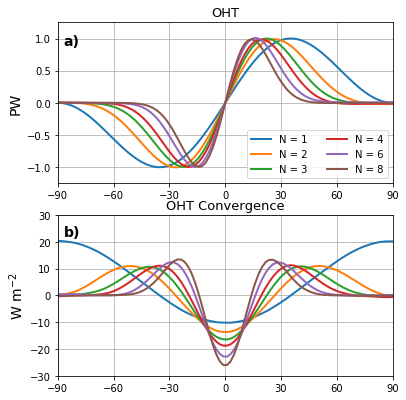

In [13]:
### Figure 1:(a) Idealized OHT profiles computed from \eqref{eq:1}, 
### shown for different values of the meridional scale parameter 
### $N$ and 1 PW peak transport; (b) Convergence of these profiles in W m$^{-2}$ 
###(the prescribed sea-surface heating in our model experiments);
fig=plt.figure(figsize=(6,6.5))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2,sharex = ax1)

for N in Nlist:
    ### OHT anomaly
    ax1.plot(lat,anom1PW.HT_ocean.sel(N=N,obliquity=0.), linewidth=2, label='N = '+str(N))
    
    ### Qflux anomaly
    ax2.plot(lat,anom1PW.SurfaceHeatFlux.sel(N=N,obliquity=0.), linewidth=2, label='N = '+str(N))
    
### setting ax1 attributes
ax1.grid()
ax1.set_xlim(-90,90)
ax1.set_xticks(range(-90,91,30))
ax1.set_ylim(-1.25,1.25)
ax1.legend(loc='lower right', ncol=2)
ax1.set_ylabel('PW', fontsize=14)
ax1.text(-87,.9,'a)', fontsize=14, fontweight='bold')
ax1.set_title('OHT', fontsize=13)  

### setting ax2 attributes
ax2.grid()
ax2.set_ylim(-30,30)
ax2.set_ylabel('W m$^{-2}$', fontsize=14)
ax2.set_title('OHT Convergence', fontsize=13)
ax2.text(-87,22,'b)', fontsize=14, fontweight='bold')

## Results

### Surface Temperature

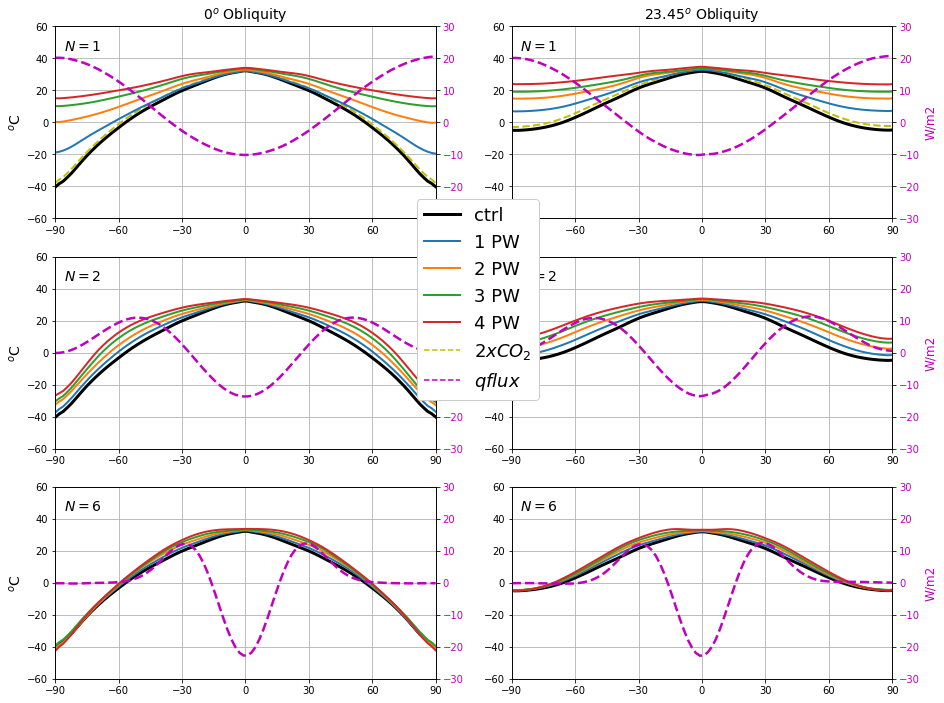

In [14]:
### Figure 2: Zonal, annual mean SST vs latitude as a function of 
### amplitude for $0^\circ$ (left) and $23.45^\circ$ (right) obliquity. 
### Each panel has a fixed meridional scale parameter $N$ as indicated. 
### The dashed magenta lines show the spatial pattern of the q-flux 
### (plotted in W m$^{-2}$ for a 1 PW peak transport).  
### Dashed yellow lines (plotted in the $N=1$ panels only) 
### show the effects of doubling CO$_2$ from the zero-OHT control states.

fig=plt.figure(figsize=(15,12))
s=1

for N in [1,2,6]:
    for o in obllist:
        ax=fig.add_subplot(3,2,s)
        
        ax.grid()
        if o==0.0:
            ax.plot(lat,ctrl.TS-273.15,'k',linewidth=3, label = 'ctrl')
            ax.set_ylabel('$^o$C', fontsize=14)
            if N==1:
                ax.plot(lat,CO2.TS-273.15,'y--',linewidth=2,label = '$2 x CO_2$')
                ax.set_title('$0^o$ Obliquity', fontsize=14)
        if o==23.45:
            ax.plot(lat,ctrl_23.TS-273.15,'k',linewidth=3,label = 'ctrl')
            
            if N==1:
                ax.plot(lat,CO2_23.TS-273.15,'y--',linewidth=2,label = '$2 x CO_2$')
                ax.set_title('$23.45^o$ Obliquity', fontsize=14)
    


        for a in amplist:
            
            ax.plot(lat,runs.TS.sel(N=N, amplitude=a,obliquity=o)-273.15,linewidth=2, label = str(a) + ' PW')
        ax2=ax.twinx()
        ax2.plot(lat,runs.SurfaceHeatFlux.sel(N=N, amplitude=1,obliquity=o),'m--',linewidth=2.5,label = 'Surface Heat Flux')
        ax2.set_ylim(-30,30)
        for tl in ax2.get_yticklabels():
            tl.set_color('m')
        if o==23.45:
            ax2.set_ylabel('W/m2',fontsize=12, color='m')
            if N==6:
                ax.plot([],'y--',label='$2 x CO_2$')
                ax.plot([],'m--',label='$qflux$')
                ax.legend(fontsize=16)
                leg=ax.legend(bbox_to_anchor=(-.25, 2.5, 1, 0), loc=2,ncol=1, borderaxespad=0.,prop={'size':18})
                leg.get_frame().set_alpha(1)
                
                
        ax.text(-86,45,'$N = $'+str(N), fontsize=14)
        ax.set_ylim(-60,60)
        ax.set_xlim(-90,90)
        ax.set_xticks(range(-90,91,30))
        s+=1

In [15]:
### Functioned used to calculate linear regress set to y-intercept at 0

def zero_regress(xi,y):

    import statsmodels.api as sm
    import numpy as np

    model = sm.OLS(y, xi)
    results = model.fit()
    
    test=results.params

    from sklearn.metrics import r2_score
    s1=test

    y_true=[xi,y]
    y_pred=[xi,s1*xi]
    r2=r2_score(y_true, y_pred)



    return s1, r2

def r_squared(xi,y,y2):
    from sklearn.metrics import r2_score
    

    y_true=[xi,y]
    y_pred=[xi,y2]
    r2=r2_score(y_true, y_pred)
    return r2

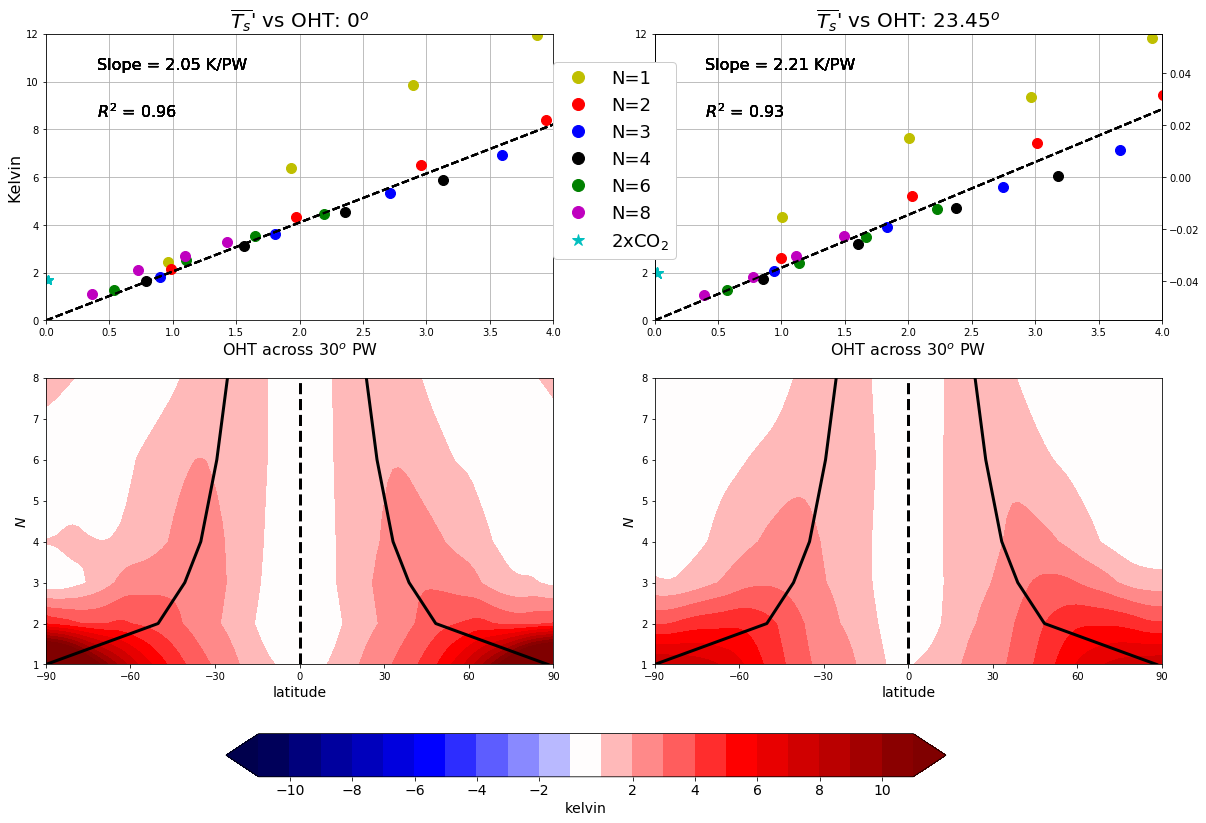

In [16]:
### Figure 3: Global mean SST anomalies with dashed linear best-fit lines (upper)
### and ``spatial anomaly plots" of SST (lower) for the $0^\circ$ obliquity (left) 
### and $23.45^\circ$ obliquity (right) cases. The contoured quantity is the SST 
### anomaly for a 1 PW increase in OHT (from 1 to 2 PW peak transport). 
### Solid and dashed lines show latitudes of maximum OHT convergence and divergence respectively.


level=[-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10,11]

fig=plt.figure(figsize=(20,12))
s=1
for o in obllist:
    ax=fig.add_subplot(2,2,s)
    for N,c in zip(Nlist,['y','r','b','k','g','m']):
        OHT_30=np.zeros(4)
        TS_global=np.zeros(4)
        for i,a in enumerate(amplist):
            OHT_30[i]=runs.HT_ocean.sel(N=N, amplitude=a, obliquity=o)[63]
            if o==0.0:
                TS_global[i]=global_mean(pert.TS.sel(N=N, amplitude=a, obliquity=o))
            if o==23.45:
                TS_global[i]=global_mean(runs.TS.sel(N=N, amplitude=a, obliquity=o) - ctrl_23.TS)
        ax.plot(OHT_30,TS_global,c+'o',markersize=10,label='N = '+str(N))
        if o==0.0:
            ax.plot(0.02,global_mean(CO2.TS-ctrl.TS),'c*', markersize=10,label='$2 x CO_2$')
            ax.set_ylabel("Kelvin", fontsize=16)
            ax.set_xlabel("OHT across $30^o$ PW", fontsize=16)
            ax.set_title("$\overline{T_s}$' vs OHT: $0^o$", fontsize=20)
            slope=2.05
            ax.text(.4,10.5, "Slope = %.2f K/PW" %2.05, fontsize=16)
            ax.text(.4,8.5,"$R^2$ = %.2f"%0.96, fontsize=16)
            x=np.arange(5)
            ax.plot(x,slope*x,'k--', linewidth=2.0)
        if o==23.45:
            ax.plot(0.02,global_mean(CO2_23.TS-ctrl_23.TS),'c*',markersize=12,label='$2 x CO_2$')
            ax.set_title("$\overline{T_s}$' vs OHT: $23.45^o$", fontsize=20)
            slope=2.21
            ax.text(.4,10.5, "Slope = %.2f K/PW" %slope, fontsize=16)
            ax.text(.4,8.5,"$R^2$ = %.2f"%0.93, fontsize=16)
            x=np.arange(5)
            ax.plot(x,slope*x,'k--', linewidth=2.0)
            ax.set_xlabel("OHT across $30^o$ PW", fontsize=16)
    ax.grid()
    ax.set_ylim(0,12)
    ax.set_yticks(range(0,13,2))
    ax.set_xlim(0,4)
    ax.set_xticks(np.arange(0,4.1,.5))
    s+=1

ax2=ax.twinx()
for N,c in zip(Nlist,['y','r','b','k','g','m']):
    ax2.plot([],c+'o',markersize=12,label='N='+str(N))
ax2.plot([],'c*',markersize=12,label='2xCO$_2$')
ax2.legend()
leg=ax2.legend(bbox_to_anchor=(-.2, .9, 1, 0), loc=2,ncol=1, borderaxespad=0.,prop={'size':18})
leg.get_frame().set_alpha(1)    
    
s=3   
for o in obllist:
    ax=fig.add_subplot(2,2,s)
    cax=spatial_plot(anom1PW.TS.sel(obliquity=o),level)
    ax.set_xlabel('latitude', fontsize=14)
    ax.set_ylabel('$N$', fontsize=14)
    s+=1
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.05])
cb=fig.colorbar(cax, cax=cbar_ax, ticks=[-10,-8,-6,-4,-2,2,4,6,8,10], orientation='horizontal');
cb.ax.tick_params(labelsize=14)
cb.set_label('kelvin',size=14)
   
    
    

### Effects of Obliquity

In [17]:
### Function from pyCESM used to calculate poleward heat transport from energy flux

def inferred_heat_transport(energy_in, lat=None, latax=None):
    '''Compute heat transport as integral of local energy imbalance.
    Required input:
        energy_in: energy imbalance in W/m2, positive in to domain
    As either numpy array or xr.DataArray
    If using plain numpy, need to supply these arguments:
        lat: latitude in degrees
        latax: axis number corresponding to latitude in the data
            (axis over which to integrate)
    returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''
    if lat is None:
        try: lat = energy_in.lat
        except:
            raise InputError('Need to supply latitude array if input data is not self-describing.')
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*energy_in
    if latax is None:
        try: latax = field.get_axis_num('lat')
        except:
            raise ValueError('Need to supply axis number for integral over latitude.')
    #  result as plain numpy array
    integral = integrate.cumtrapz(field, x=lat_rad, initial=0., axis=latax)
    result = (1E-15 * 2 * np.math.pi * physconst.rearth**2 * integral)
    if isinstance(field, xr.DataArray):
        result_xarray = field.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

Text(0.5,0,'latitude')

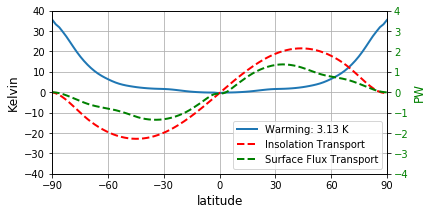

In [18]:
### Figure 4: Anomalies in SST, insolation (expressed as a meridional transport), 
### and annual-mean SW flux reaching the surface (expressed as a meridional transport) 
### for an obliquity increase from $0^\circ$ to $23.45^\circ$. Global mean warming is 3.13 K.

value=(1- (ctrl.ALBtoa))*ctrl.SOLIN - global_mean((1- (ctrl.ALBtoa))*ctrl.SOLIN)
value1=(1.-(ctrl_23.ALBtoa))*ctrl_23.SOLIN - global_mean((1- (ctrl_23.ALBtoa))*ctrl_23.SOLIN)
lat_test=np.arange(-90,91,1)

fig=plt.figure(figsize=(6,3))
ax1=plt.subplot(111)
ax1.plot(lat,ctrl_23.TS-ctrl.TS,linewidth=2.0,label='Warming: %.2f K'% global_mean(ctrl_23.TS-ctrl.TS)) 



ax1.grid()


test=-inferred_heat_transport(np.interp(lat_test,lat,value1)-np.interp(lat_test,lat,value),lat_test,latax=0)
   



test1=-inferred_heat_transport(np.interp(lat_test,lat,ctrl_23.SOLIN)-np.interp(lat_test,lat,ctrl.SOLIN),lat_test,latax=0)


ax1.plot(lat_test-1,test1*10.,'r--',linewidth=2.0,label='Insolation Transport')
ax1.plot(lat_test,test*10.,'g--',linewidth=2.0,label='Surface Flux Transport')

plt.legend(loc='lower right', fontsize=10)

ax2 = ax1.twinx()
ax1.axis([-90,90,-40,40])
for tl in ax2.get_yticklabels():
    tl.set_color('g')
plt.xticks(range(-90,91,30))

ax2.set_ylim(-4,4)



ax2.set_ylabel('PW',fontsize=12, color='g')

ax1.set_ylabel('Kelvin',fontsize=12)
ax1.set_xlabel('latitude', fontsize=12)

### Evaporation and hydrological cycle

Text(-85,7.3,'c) Precipitation')

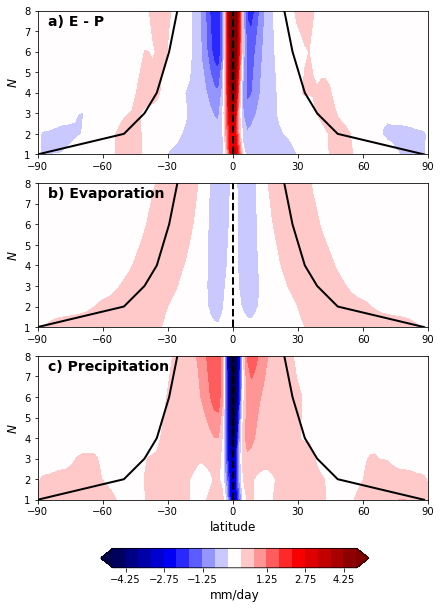

In [19]:
### Figure 5: Spatial anomaly plots (for a 1 PW increase in OHT from 1 to 2 PW, as in Fig. 3,
### plotted for 0$^\circ$ obliquity only) of (a) E - P, (b) evaporation, and (c) precipitation in mm/day.

levs = [-4.75,-4.25,-3.75,-3.25,-2.75,-2.25,-1.75,-1.25,-.75,-.25,.25,.75,1.25,1.75,2.25,2.75,3.25,3.75,4.25,4.75]
ticks=[-4.25,-2.75,-1.25,1.25,2.75,4.25]
fields = [anom1PW.sel(obliquity=0.).EminusP*3600*24., 
          anom1PW.sel(obliquity=0.).Evap*3600*24.,
          anom1PW.sel(obliquity=0.).Precip*3600*24.]


#names = ['Evap', 'Precip', 'E - P']

fig, axes = plt.subplots(3,1,figsize=(7,9))
for n, field in enumerate(fields):
    ax = axes[n]
    cax=ax.contourf(lat,Nlist,field,
        cmap=plt.cm.seismic, levels=levs, extend='both')
    ax.plot(left_max,Nlist,'k',linewidth=2.)
    ax.plot(right_max,Nlist,'k',linewidth=2.)
    ax.plot(minimum,Nlist,'k--',linewidth=2.)
    ax.set_xticks(range(-90,91,30))
    ax.set_ylabel('$N$', fontsize=12)
    #ax.set_title(names[n])
    n=2
    ax = axes[n] 
    ax.set_xlabel('latitude',fontsize=12)
    
fig.subplots_adjust(bottom=0.125)
cbar_ax = fig.add_axes([0.25, 0.02, 0.5325, 0.03])
cb=fig.colorbar(cax, cax=cbar_ax,ticks=ticks, orientation='horizontal');
cb.set_label('mm/day',size=12)

axes[0].text(-85,7.3,'a) E - P',fontsize=14, fontweight='bold')
axes[1].text(-85,7.3,'b) Evaporation',fontsize=14, fontweight='bold')
axes[2].text(-85,7.3,'c) Precipitation',fontsize=14, fontweight='bold')

#### Evaporation Analysis: Section A2



- The change in the latent heat flux can be thought of as the change in the surface evaporation multiplied by the latent heat of vaporization.

- $LHF = L_{vap} E \rightarrow LHF' = L_{vap} E'$





Following Lorenz et al. (2010), we will analyze evaporation change through a simple bulk formula for air-sea flux:

$$ E = k \left( q_s(T_s) - r q_s(T_a) \right) $$

where $E$ is evaporation, $q_s(T)$ is the saturation specific humidity (function of temperature), $r$ is the near-surface relative humidity, and $k$ is the turbulent exchange coefficient that depends on wind speed and static stability.

Taking the fractional derivative with respect to near-surface air temperature $T_a$ gives 

$$ \frac{d \ln E}{dT_a} = \alpha - \frac{(1-\gamma) \alpha q_s(T_s)}{q_s(T_s) - r q_s(T_a)} - \frac{\frac{dr}{dT_a} q_s(T_a)}{q_s(T_s) - r q_s(T_a)} + \frac{d \ln k}{dT_a} $$


$$\frac{d \ln k}{dT_a} =  \frac {d \ln (\rho C)}{d T_a}+ \frac {d \ln |\vec{U}|} {dT_a}$$


(equation (9) from Lorenz et al. (2010)), where $\gamma = \frac{d T_s}{d T_a}$ is the ratio of SST change to the near-surface air temperature change.

The physical meaning of each term on the RHS is:

1. The CC rate $\frac{1}{q_s}\frac{dq_s}{dT}$
2. Effect of change in air-sea temperature difference
3. Effect of changes in relative humidity
4. Effect of changes in the exchange coefficient (dynamical changes)

In [20]:
def frac_anom(field,control):
    return np.log(field) - np.log(control)

Text(0,0.5,'% / K')

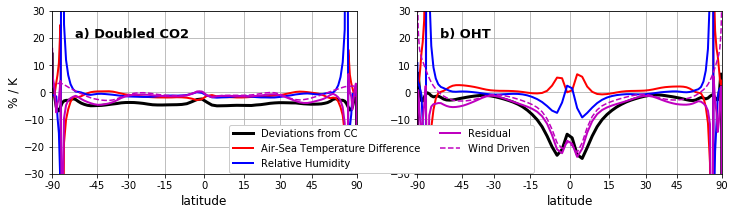

In [21]:
### Figure 6: Breakdown of the contributions to surface evaporation anomalies, 
### expressed as deviations of the fractional evaporation changes away from the Clausius-Clapeyron rate 
### (roughly $7\%$/K) following the method of \citet{Lorenz:2010} (left) for doubled CO$_2$ and (right) 
### a 1 PW increase in OHT for $N=4$ (plotted for 0$^\circ$ obliquity).



ps = 1000.  # pressure in units of mb or hPa unless otherwise noted
mb_to_Pa = 100.  # conversion factor from mb to Pa
tempCtoK = 273.15   # 0degC in Kelvin
tempKtoC = -tempCtoK  # 0 K in degC
seconds_per_day = 60.*60.*24.

#  physical constants defined in CESM code:
g = pyCESM.physconst.gravit
Rd = pyCESM.physconst.rair
Lhvap = pyCESM.physconst.latvap
Rv = pyCESM.physconst.rh2o
a = pyCESM.physconst.rearth
cp = pyCESM.physconst.cpair
def alpha(T):
    '''Approximate Clausius-Clapeyron scaling of water vapor change in %/K.'''
    return Lhvap / Rv / T**2 * 100.

alpha_ctrl = alpha(ctrl.TREFHT)

def calculate_humidity(run):
    Ts = run.TS
    Ta = run.TREFHT

    es, qs, gam, dqsdt, enthalpy = pyCESM.wv_saturation.qsat(Ts, ps*mb_to_Pa, method='GoffGratch')
    es, qa, gam, dqsdt, enthalpy = pyCESM.wv_saturation.qsat(Ta, ps*mb_to_Pa, method='GoffGratch')

    qs = xr.DataArray(qs, coords=Ts.coords)
    qs.name = 'QS'
    qs.attrs['long_name'] = u'Saturation specific humidity at surface temperature'
    qs.attrs['units'] = u'kg/kg'

    qa = xr.DataArray(qa, coords=Ta.coords)
    qa.name = 'QA'
    qa.attrs['long_name'] = u'Saturation specific humidity at reference height temperature'
    qa.attrs['units'] = u'kg/kg'

    r = run.QREFHT / qa
    r.name = 'RHREFHT'
    r.attrs['long_name'] = u'Reference height relative humidity'
    r.attrs['units'] = u'-'
    
    return Ts, Ta, qs, qa, r
#  calculate q_s, q_a and r from control run
Ts, Ta, qs, qa, r = calculate_humidity(ctrl)




these_runs = [CO2, runs.sel(N=4, amplitude=2,obliquity=0)]#,'N3_1PW','N4_1PW','N6_1PW','N8_1PW','N2_3PW','N6_3PW']
ticks = [-90, -45, -30, -15, 0, 15, 30, 45, 90]
sticks = np.sin(np.deg2rad(ticks))
slat = np.sin(np.deg2rad(lat))
fig, axarray = plt.subplots(1,2,figsize=(12,3))
for n, run in enumerate(these_runs):
    if n==0:
        title='a) Doubled CO2'
        
    else:
        title='b) OHT'
    Ts_pert, Ta_pert, qs_pert, qa_pert, r_pert = calculate_humidity(run)
    drdTa = (r_pert - r) / (Ta_pert - Ta)
    gamma = (Ts_pert - Ts) / (Ta_pert - Ta)
    denom = qs - r*qa
    
    evap = frac_anom(run.Evap,ctrl.Evap)*100. / (run.TREFHT-ctrl.TREFHT)
    term1 = alpha_ctrl
    term2 = -(1-gamma)*alpha_ctrl*qs/denom
    term3 = -drdTa*qs/denom*100.  # in %/K
    #  dynamical term is calculated as residual
    term4 = evap - term1 - term2 - term3
    wind_driven=frac_anom(run.U10,ctrl.U10)*100./(run.TREFHT-ctrl.TREFHT)
    ax = axarray.flatten()[n]
    ax.plot(slat, evap - term1, 'k-', label='Deviations from CC', linewidth=3)
    #ax.plot(slat, term1, 'k--', label='\alpha', linewidth=1)
    ax.plot(slat, term2, 'r-', label='Air-Sea Temperature Difference', linewidth=2)
    ax.plot(slat, term3, 'b-', label='Relative Humidity', linewidth=2)
    ax.plot(slat, term4, 'm-', label='Residual', linewidth=2)
    ax.plot(slat, wind_driven,'m--', label='Wind Driven')
    #ax.set_title(title, fontsize=14)
    ax.text(-.85,20, title, fontsize = 13, fontweight='bold')
    ax.set_xticks(sticks);
    ax.set_xticklabels(ticks);
    ax.set_xlim(-1,1)
    ax.set_xlabel('latitude', fontsize=12)
    ax.set_ylim(-25,25)
    ax.set_yticks(range(-30,31,10))
    ax.grid()  
    plt.legend(fontsize=20)
leg=plt.legend(bbox_to_anchor=(-.62, .25, 1, 0.05), loc=2,ncol=2, borderaxespad=0.,prop={'size':10})
leg.get_frame().set_alpha(1) 

axarray[0].set_ylabel('% / K', fontsize=12)


### Atmospheric Compensation

$$F_{tot}(\phi)=2 \pi a^2 \int_{-\frac{\pi}{2}}^{\phi} \left( \left[\overline{Q}_{TOA}\right]-\left[\overline{Q}_{sfc}\right]\right) \cos\phi  d\phi$$

$$F_{HC}(\phi)=2 \pi a \cos \phi \int_{P_{top}}^{P_{sfc}}\big[\overline{m}\big]\big[\overline{v}\big]_{adj}\frac{dp}{g}$$

$$\psi(\phi,p)=2 \pi a \cos{\phi} \int^p_0 [\overline{v}]_{adj} \frac{dp}{g}$$

Text(-85,5.8,'c) OHT')

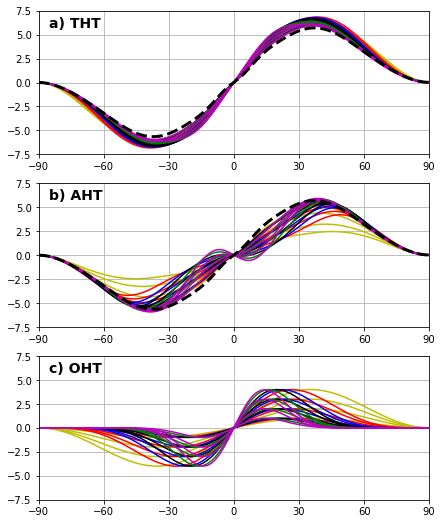

In [22]:
### Figure 7: Zonally averaged (a) THT, (b) AHT, and (c) OHT 
### for all runs with line colors grouped by $N$. The dashed black line is the control 
### THT and AHT (plotted for 0$^\circ$ obliquity).

fields=[runs.HT_total,runs.HT_atm,runs.HT_ocean]


fig, axes = plt.subplots(3,1,figsize=(7,9))





for n,field in enumerate(fields):
    ax=axes[n]

    for N,c in zip(Nlist,['y','r','b','k','g','m']):
    
        for a in amplist:
            ax.plot(lat,field.sel(N=N,amplitude=a,obliquity=0.0),c)
    ax.grid()
    ax.set_xlim(-90,90)
    ax.set_xticks(range(-90,91,30))
    ax.set_ylim(-7.5,7.5)
    ax.set_yticks(np.arange(-7.5,7.6,2.5))
axes[0].plot(lat,ctrl.HT_total,'k--',linewidth=3)   
axes[0].text(-85,5.8,'a) THT',fontsize=14, fontweight='bold')
axes[1].plot(lat,ctrl.HT_atm,'k--',linewidth=3)  
axes[1].text(-85,5.8,'b) AHT',fontsize=14, fontweight='bold')
axes[2].text(-85,5.8,'c) OHT',fontsize=14, fontweight='bold')

In [23]:
### Function for calculating HC mass flux
def mass_flux(run):
    psi = run.Psi
    t=np.zeros_like(lat)
    n=np.copy(t)
    mass_max=np.copy(t)
    for m in range(len(t)):
        t[m]=np.amax(psi[:,m])
        n[m]=np.amin(psi[:,m])

        if abs(t[m])>=abs(n[m]):
            mass_max[m]=t[m]
        else:
            mass_max[m]=n[m]

    mass_max=np.asarray(mass_max)*10**9
    return mass_max




Text(-75,6.5,'flux')

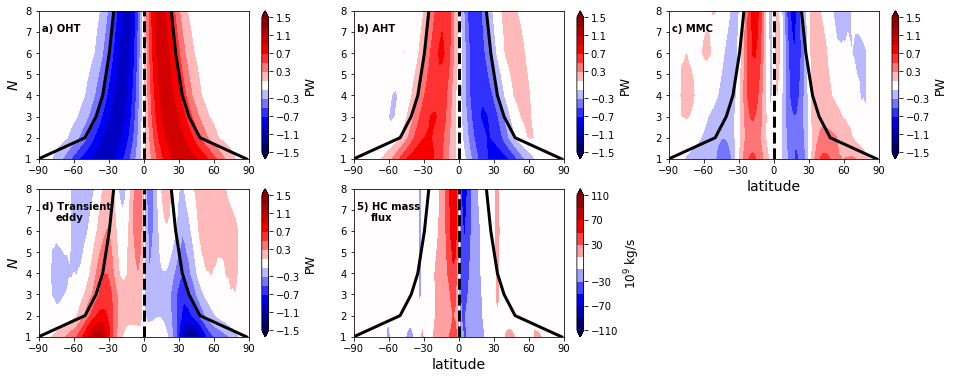

In [24]:
### Figure 8: Spatial anomaly plots (as in Fig. 3, 
### for 0$^\circ$ obliquity only) for (a) total OHT, (b) total AHT, 
### (c) the transient eddy component of AHT, (d) the MMC component of AHT, (e) and the HC mass flux.

level=[-1.5,-1.3,-1.1,-.9,-.7,-.5,-.3,-.1,.1,.3,.5,.7,.9,1.1,1.3,1.5]
level2=[-110,-90,-70,-50,-30,-10,10,30,50,70,90,110]

ticks=[-1.5,-1.1,-.7,-.3,.3,.7,1.1,1.5]
ticks2=[-110,-70,-30,30,70,110]

fig=plt.figure(figsize=(16,6))

ax1=fig.add_subplot(2,3,1)
cax=spatial_plot(anom1PW.HT_ocean.sel(obliquity=0),level)
ax1.set_ylabel('$N$', fontsize=14)
ax1.text(-87,7, 'a) OHT', fontweight='bold')
cbar=plt.colorbar(cax,ticks=ticks)
cbar.set_label('PW',size=12)

ax2=fig.add_subplot(2,3,2)
cax=spatial_plot(anom1PW.HT_atm.sel(obliquity=0),level)
cbar=plt.colorbar(cax,ticks=ticks)
cbar.set_label('PW',size=12)
ax2.text(-87,7, 'b) AHT', fontweight='bold')

ax3=fig.add_subplot(2,3,3)

cax=spatial_plot(anom1PW.HC_flux.sel(obliquity=0),level)
ax3.text(-87,7, 'c) MMC', fontweight='bold')
ax3.set_xlabel('latitude', fontsize=14)
cbar=plt.colorbar(cax,ticks=ticks)
cbar.set_label('PW',size=12)


ax4=fig.add_subplot(2,3,4)

cax=spatial_plot(anom1PW.TE_flux.sel(obliquity=0),level)

ax4.text(-87,7, 'd) Transient', fontweight='bold')
ax4.text(-75,6.5, 'eddy', fontweight='bold')
ax4.set_ylabel('$N$', fontsize=14)
cbar=plt.colorbar(cax, ticks=ticks)
cbar.set_label('PW',size=12)

ax5=fig.add_subplot(2,3,5)
mass_anom=np.zeros_like(anom1PW.TE_flux.sel(obliquity=0))
for i,N in enumerate(Nlist):
    mass_anom[i,:]=mass_flux(runs.sel(N=N,amplitude=2,obliquity=0))-mass_flux(runs.sel(N=N,amplitude=1,obliquity=0))
cax=spatial_plot(mass_anom/1E9,level2)
cbar=plt.colorbar(cax, ticks=ticks2)
cbar.set_label('$10^9$ kg/s',size=12)
ax5.set_xlabel('latitude', fontsize=14)
ax5.text(-87,7, '5) HC mass', fontweight='bold')
ax5.text(-75,6.5, 'flux', fontweight='bold')

### TOA energy budget and clouds

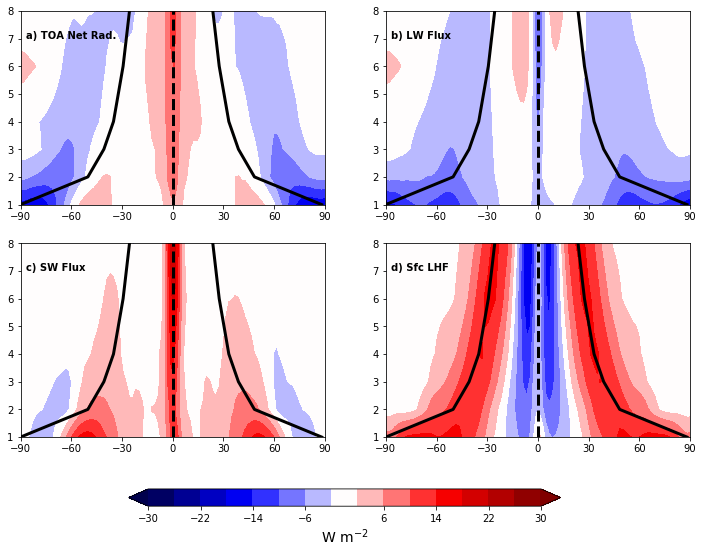

In [25]:
### Figure 9:Spatial anomaly plots (as in Fig. 3, 
### for 0$^\circ$ obliquity only) of (a) TOA net radiative flux, 
### (b) TOA LW radiative flux, (c) TOA SW radiative flux, and (d) SFC LHF. 
### The sign convention is positive down at TOA (panels (a) through (c)) and positive up at the surface (d).

levs = [-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30]
ticks = [-30,-22,-14,-6,6,14,22,30]
fields=[anom1PW.Rtoa.sel(obliquity=0),-anom1PW.OLR.sel(obliquity=0),anom1PW.ASR.sel(obliquity=0),anom1PW.LHF.sel(obliquity=0)]
field_label=['a) TOA Net Rad.','b) LW Flux','c) SW Flux','d) Sfc LHF']
fig= plt.figure(figsize=(12,8))
for n, field in enumerate(fields):
    ax=fig.add_subplot(2,2,n+1)
    cax=spatial_plot(field,levs)
    ax.text(-87,7,field_label[n],fontweight='bold')
    
fig.subplots_adjust(bottom=0.14)
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
cb=fig.colorbar(cax, cax=cbar_ax, ticks=ticks, orientation='horizontal');
cb.set_label('W m$^{-2}$',size=14)    
    


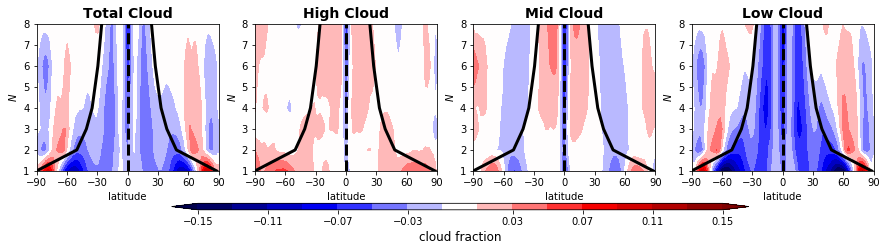

In [26]:
### Figure 10: Cloud fraction anomalies (as in Fig. 3, 
### for 0$^\circ$ obliquity only), vertically integrated for the (a) total atmosphere, 
### (b) high cloud fraction anomalies vertically integrated for cloud top pressures (CTP) 
### less than $440$ hPa, (c) mid cloud anomalies vertically integrated for CTP between $680$ 
### and $440$ hPa, (d) and low cloud anomalies vertically integrated for CTP greater than $680$ hPa.

levs = [-.15,-.13,-.11,-.09,-.07,-.05,-.03,-.01,.01,.03,.05,.07,.09,.11,.13,.15]
ticks = [-.15,-.11,-.07,-.03,.03,.07,.11,.15]

fields=[anom1PW.CLDTOT.sel(obliquity=0),anom1PW.CLDHGH.sel(obliquity=0),anom1PW.CLDMED.sel(obliquity=0),anom1PW.CLDLOW.sel(obliquity=0)]
field_label=['Total Cloud', 'High Cloud', 'Mid Cloud', 'Low Cloud']
fig=plt.figure(figsize=(15,3))
for n,field in enumerate(fields):
    ax=fig.add_subplot(1,4,n+1)
    cax=spatial_plot(field,levs)
    ax.set_xlabel('latitude')
    ax.set_ylabel('$N$')
    ax.set_title(field_label[n], fontsize=14, fontweight='bold')
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.25, 0.02, 0.5345, 0.03])
cb=fig.colorbar(cax, cax=cbar_ax,ticks=ticks, orientation='horizontal');
cb.set_label('cloud fraction',size=12)

#### New Greenhouse Trapping Breakdown: Section A3

$$  \Delta G_t =  \Delta F_s^{\uparrow} - \Delta OLR$$

$$ \Delta G_t^* = \Delta F_s^{\uparrow} - \Delta OLR^{clear} $$

$$\Delta G_t^{clear} = (1-c) \Delta G_t^*  $$ 

$$\Delta G_t^{cloud} =  c \left[ \Delta F_s^{\uparrow}  - \Delta OLR^{cloudy}  -  \frac{\Delta c}{c} \left( OLR^{cloudy} - OLR^{clear}  \right)\right]$$

Text(-85,7.3,'c) Cloud Trapping')

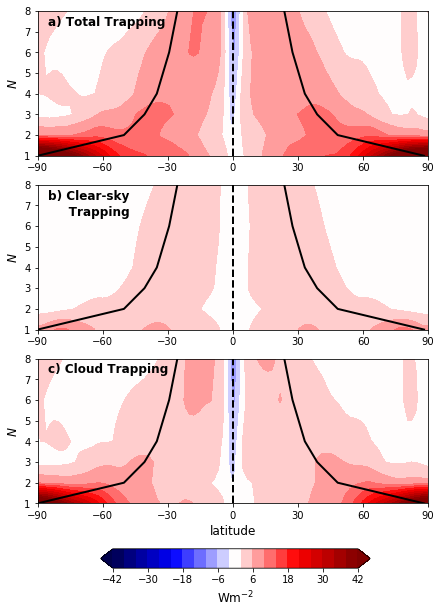

In [27]:
### Figure 11: Anomalies of greenhouse trapping (as in Fig. 3, 
### for 0$^\circ$ obliquity only), decomposed into (a) total, (b) clear-sky, and (c) cloud components.


levs = [-42,-38,-34,-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30,34,38,42]
ticks=[-42,-30,-18,-6,6,18,30,42]

c=runs.CLDTOT.sel(obliquity=0, amplitude=1)
delta_c=anom1PW.CLDTOT.sel(obliquity=0)
es=0.98
sigma=5.67E-8
delta_Fs=es*sigma*(runs.TS.sel(obliquity=0,amplitude=2)**4-runs.TS.sel(obliquity=0,amplitude=1)**4)
delta_OLR=anom1PW.OLR.sel(obliquity=0)
delta_OLR_clr=anom1PW.OLRclr.sel(obliquity=0)
delta_OLR_cld=anom1PW.OLRcld.sel(obliquity=0)
delta_Gt1=delta_Fs-delta_OLR

delta_Gt_star=delta_Fs-delta_OLR_clr

delta_Gt_clr=(1-c)*delta_Gt_star

delta_CRE_lw=c*(delta_OLR_clr-delta_OLR_cld)+\
delta_c*(runs.OLRclr.sel(obliquity=0,amplitude=1)-runs.OLRcld.sel(obliquity=0,amplitude=1))

delta_CRE_lw=(runs.OLRclr.sel(obliquity=0, amplitude=2)-runs.OLR.sel(obliquity=0, amplitude=2))-(runs.OLRclr.sel(obliquity=0, amplitude=1)-runs.OLR.sel(obliquity=0, amplitude=1))


delta_Gt_cld=c*delta_Gt_star+delta_CRE_lw


delta_Gt2=delta_Gt_clr+delta_Gt_cld



fields = [delta_Gt1, delta_Gt_clr, delta_Gt_cld]

names = ['Total GH Trapping', 'Clear-sky GH trapping', 'Cloud GH trapping']
fig, axes = plt.subplots(3,1,figsize=(7,9))
for n, field in enumerate(fields):
    ax = axes[n]
    cax=ax.contourf(lat,Nlist,field,
        cmap=plt.cm.seismic, levels=levs, extend='both')
    ax.plot(left_max,Nlist,'k',linewidth=2.)
    ax.plot(right_max,Nlist,'k',linewidth=2.)
    ax.plot(minimum,Nlist,'k--',linewidth=2.)
    ax.set_xticks(range(-90,91,30))
    ax.set_ylabel('$N$', fontsize=12)
    #ax.set_title(names[n])
fig.subplots_adjust(bottom=0.12)
cbar_ax = fig.add_axes([0.25, 0.02, 0.535, 0.03])
cb=fig.colorbar(cax, cax=cbar_ax,ticks=ticks, orientation='horizontal');
cb.set_label('Wm$^{-2}$',size=12)
axes[2].set_xlabel('latitude', fontsize=12)
axes[0].text(-85,7.3,'a) Total Trapping',fontsize=12, fontweight='bold')
axes[1].text(-85,7.3,'b) Clear-sky',fontsize=12, fontweight='bold')
axes[1].text(-85,6.5,'     Trapping',fontsize=12, fontweight='bold')
axes[2].text(-85,7.3,'c) Cloud Trapping',fontsize=12, fontweight='bold')

Text(0.5,0,'latitude')

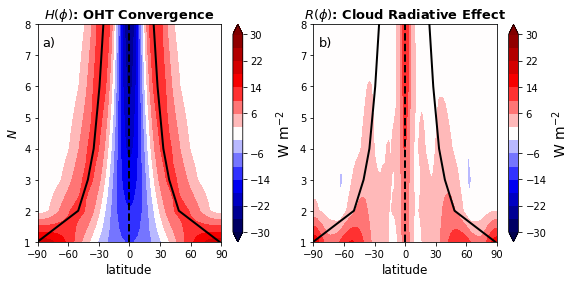

In [28]:
### Figure 12: Spatial anomaly plots (as in Fig. 3, for 0$^\circ$ obliquity only) 
### of (a) OHT convergence, (b) Cloud Radiative effect, and (c) clear-sky feedbacks.

levs = np.arange(-30,31,4)
ticks=[-30,-22,-14,-6,6,14,22,30]
fig=plt.figure(figsize=(14,4))
plt.subplot(131)
plt.contourf(lat,Nlist,anom1PW.sel(obliquity=0.).OHTconvergence,cmap=plt.cm.seismic, levels=levs, extend='both')
plt.plot(left_max,Nlist,'k',linewidth=2.)
plt.plot(right_max,Nlist,'k',linewidth=2.)
plt.plot(minimum,Nlist,'k--',linewidth=2.)
plt.text(-85,7.3,'a)',fontsize=13)
plt.xticks(range(-90,91,30))
plt.xlabel('latitude', fontsize=12)
plt.ylabel('$N$', fontsize=12)
plt.title('$H(\phi)$: OHT Convergence', fontsize=13, fontweight='bold')
cb=plt.colorbar(ticks=ticks)
cb.set_label('W m$^{-2}$',size=14)
plt.subplot(132)
plt.contourf(lat,Nlist,anom1PW.sel(obliquity=0.).Rtoacld,cmap=plt.cm.seismic, levels=levs, extend='both')
plt.plot(left_max,Nlist,'k',linewidth=2.)
plt.plot(right_max,Nlist,'k',linewidth=2.)
plt.plot(minimum,Nlist,'k--',linewidth=2.)
plt.title('$R(\phi)$: Cloud Radiative Effect', fontsize=13, fontweight='bold')
plt.text(-85,7.3,'b)',fontsize=13)
plt.xticks(range(-90,91,30))
cb=plt.colorbar(ticks=ticks)
cb.set_label('W m$^{-2}$',size=14)
plt.xlabel('latitude', fontsize=12)
